In [1]:
# Loading library
import os
os.sys.path.append("../")
from scripts.etl_pipeline import *

In [2]:
# Create a Spark Session
spark = (
    SparkSession.builder.appName("ETL Pipeline")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/10 00:05:34 WARN Utils: Your hostname, DESKTOP-H0CEB6G resolves to a loopback address: 127.0.1.1; using 172.29.253.151 instead (on interface eth0)
24/09/10 00:05:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 00:05:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Extract

As we can't use `urlretrieve` to get the data from Canvas, please download it to your local machine and move it `data/tables`. Then run the code below to unzip the files

In [3]:
# Assign data path
raw_path = "../data"

# Unzip files (Only run once)
"""
for file in os.listdir(f"{raw_path}/tables"):
    if file == ".gitkeep":
        continue
    with zipfile.ZipFile(f"{raw_path}/tables/{file}", "r") as zip_ref:
        zip_ref.extractall(f"{raw_path}/")
    os.remove(f"{raw_path}/tables/{file}")
"""

'\nfor file in os.listdir(f"{raw_path}/tables"):\n    if file == ".gitkeep":\n        continue\n    with zipfile.ZipFile(f"{raw_path}/tables/{file}", "r") as zip_ref:\n        zip_ref.extractall(f"{raw_path}/")\n    os.remove(f"{raw_path}/tables/{file}")\n'

# Transform

The system use `user_id` as a key for identifying customer in transactions record and fraud probability tables. However, they also have a key-value map of `user_id` and `consumer_id`. We will use `consumer_id` as the only ID for customer. Thus, we will map `user_id` from each table to `consumer_id` and drop the former.


In [4]:
# Load consumer user details -> a key:value map for user_id to consumer_id
consumer_user_map = spark.read.parquet(f"{raw_path}/tables/consumer_user_details.parquet")
consumer_user_map.limit(5) # Preview

user_id,consumer_id
1,1195503
2,179208
3,1194530
4,154128
5,712975


In [5]:
# Load consumer fraud rate dataset
consumer_fraud_rate = spark.read.csv(f"{raw_path}/tables/consumer_fraud_probability.csv", header=True, inferSchema=True)
consumer_fraud_rate.show(5)
get_dataset_count(consumer_fraud_rate)

# Replace all user_id with unique consumer_id
consumer_fraud_rate = replace_id(consumer_user_map, consumer_fraud_rate)
consumer_fraud_rate.show(5)

# Check to make sure no rows were lost on the inner join
get_dataset_count(consumer_fraud_rate)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
+-------+--------------+-----------------+
only showing top 5 rows

The dataset count is  34864
+--------------+------------------+-----------+
|order_datetime| fraud_probability|consumer_id|
+--------------+------------------+-----------+
|    2022-02-20| 9.805431136520959|    1195503|
|    2021-08-30| 9.599513915425788|     179208|
|    2021-09-25|10.069850934775245|     179208|
|    2021-11-03| 8.300636455314633|    1194530|
|    2021-10-09| 9.633302411090419|     154128|
+--------------+------------------+-----------+
only showing top 5 rows

The dataset count is  34864


In [6]:
# Load all the transaction data 
transaction_p1 = spark.read.parquet(f"{raw_path}/tables/transactions_20210228_20210827_snapshot")
transaction_p2 = spark.read.parquet(f"{raw_path}/tables/transactions_20210828_20220227_snapshot")
transaction_p3 = spark.read.parquet(f"{raw_path}/tables/transactions_20220228_20220828_snapshot")

# Combine the datasets
transaction_records = reduce(DataFrame.unionAll, [transaction_p1, transaction_p2, transaction_p3])
transaction_records.show(5)
get_dataset_count(transaction_records)

# Replace user_id with consumer_id after combining
transaction_records = replace_id(consumer_user_map, transaction_records)
transaction_records.show(5)

# Check to make sure no rows were lost on the inner join
get_dataset_count(transaction_records)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



The dataset count is  14195505


+------------+------------------+--------------------+--------------+-----------+
|merchant_abn|      dollar_value|            order_id|order_datetime|consumer_id|
+------------+------------------+--------------------+--------------+-----------+
| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|     651338|
| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|     179208|
| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|     467663|
| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|    1194530|
| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|     467663|
+------------+------------------+--------------------+--------------+-----------+
only showing top 5 rows



The dataset count is  14195505


Now that replacing `user_id` to `consumer_id` is done, load all other data and clean them

In [7]:
# Load merchant fraud probability
# merchant_fraud_rate = spark.read.csv(f"{raw_path}/tables/merchant_fraud_probability.csv", header=True, inferSchema=True)

# date_pattern = r"^\d{4}-\d{2}-\d{2}$"

# test = merchant_fraud_rate.withColumn("is_valid_date", F.regexp_extract(F.col("order_datetime"), date_pattern, 0))
# invalid_dates = test.filter(F.col("is_valid_date") == "")
# invalid_dates

In [8]:
# Load consumer fraud rate dataset
merchant_fraud_rate = spark.read.csv(f"{raw_path}/tables/merchant_fraud_probability.csv", header=True, inferSchema=True)
merchant_fraud_rate.show(5)
get_dataset_count(merchant_fraud_rate)

# Display some info on the merchants
print(f'Total number of merchants: {transaction_records.select("merchant_abn").distinct().count()}')
print(f'Total number of merchants with fraudulent probability: {merchant_fraud_rate.select("merchant_abn").distinct().count()}')

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
+------------+--------------+------------------+
only showing top 5 rows

The dataset count is  114


Total number of merchants: 4422
Total number of merchants with fraudulent probability: 61


In [9]:
# Group by merchant_abn and count the number of entries for each merchant
merchant_counts = merchant_fraud_rate.groupBy("merchant_abn").count()

# Show the result
merchant_counts.show()

+------------+-----+
|merchant_abn|count|
+------------+-----+
| 99989036621|    1|
| 90568944804|    3|
| 29674997261|    1|
| 27093785141|    3|
| 19492220327|    8|
| 76968105359|    1|
| 97884414539|    1|
| 82999039227|    1|
| 83199298021|    6|
| 93292821052|    1|
| 43083074133|    1|
| 15157368385|    1|
| 76767266140|    1|
| 96680767841|    1|
| 35909341340|    1|
| 72058040180|    1|
| 19010030815|    3|
| 39649557865|    1|
| 48534649627|    3|
| 85482742429|    1|
+------------+-----+
only showing top 20 rows



In [10]:
from pyspark.sql.functions import avg

average_fraud_probability = merchant_fraud_rate.groupBy("merchant_abn").agg(avg("fraud_probability").alias("average_fraud_probability"))

average_fraud_probability.show()

+------------+-------------------------+
|merchant_abn|average_fraud_probability|
+------------+-------------------------+
| 99989036621|        18.21089142894488|
| 90568944804|        30.72298492113958|
| 29674997261|        44.43787807900268|
| 27093785141|        28.88064813052203|
| 19492220327|       31.958306675667547|
| 76968105359|        68.27843632543912|
| 97884414539|        89.79919971536573|
| 82999039227|         94.1347004808891|
| 83199298021|        31.93490297074105|
| 93292821052|        66.58725735032715|
| 43083074133|        48.66890735193894|
| 15157368385|         64.2774131928303|
| 76767266140|       29.539733207182703|
| 96680767841|       29.555244690425017|
| 35909341340|        29.13305311007307|
| 72058040180|        33.71875978884334|
| 19010030815|       51.033927919712056|
| 39649557865|       28.690204286050616|
| 48534649627|        28.56793296472796|
| 85482742429|        70.88131110541714|
+------------+-------------------------+
only showing top

Cleaning `tbl_merchants.parquet`. The feature `tags` is a string that represents either a tuple or a list, containing 3 elements:
* Items that are being sold
* Revenue levels
* Commission rate

Each elements either a list, a tuple, or a combination of both (e.g starts with `[` and ends with `)` and vice versa). These inconsistencies are mostly due to human errors. Thus, we need to take into account these consistent when splitting the values of the feature `tags` into separate columns

In [11]:
# Load merchant's info
merchant_info = spark.read.parquet(f"{raw_path}/tables/tbl_merchants.parquet")
merchant_info.show(5, truncate=False)

# Clean the data
merchant_info = clean_merchant_details(merchant_info)
merchant_info.show(5, truncate=False)

# Check if there are any remaining brackets
merchant_info.select("category").filter(
    (F.col("category").rlike(r"^[\(\[\{]")) | 
    (F.col("category").rlike(r"[\)\]\}]$"))
).show(truncate=False)

# merchant_info.groupBy(F.col("revenue_level")).agg(F.avg(F.col("take_rate"))) # average commission rate of each revenue level

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+
|name                                |tags                                                                                                             |merchant_abn|
+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+
|Felis Limited                       |((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))|10023283211 |
|Arcu Ac Orci Corporation            |([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])                        |10142254217 |
|Nunc Sed Company                    |([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])                                          |10165489824 |
|Ult

The dataset count is  4026
+------------------------------------+------------+-------------------------------------------------------------------------------------+-------------+---------+
|name                                |merchant_abn|category                                                                             |revenue_level|take_rate|
+------------------------------------+------------+-------------------------------------------------------------------------------------+-------------+---------+
|Felis Limited                       |10023283211 |furniture, home furnishings and equipment shops, and manufacturers, except appliances|e            |0.18     |
|Arcu Ac Orci Corporation            |10142254217 |cable, satellite, and other pay television and radio services                        |b            |4.22     |
|Nunc Sed Company                    |10165489824 |jewelry, watch, clock, and silverware shops                                          |b            |4.4      |
|

In [12]:
# Load consumer info's
consumer_info = spark.read.csv(f"{raw_path}/tables/tbl_consumer.csv", header=True, inferSchema=True)
consumer_info.show(5, truncate=False)

# Clean the data
consumer_info = clean_consumer_details(consumer_info)
consumer_info.show(5, truncate=False)

# consumer_info.groupBy("gender").count() # relatively same proportion of female and male customer, only a small percentage of did not provide their gender

+---------------------------------------------------------------------+
|name|address|state|postcode|gender|consumer_id                       |
+---------------------------------------------------------------------+
|Yolanda Williams|413 Haney Gardens Apt. 742|WA|6935|Female|1195503   |
|Mary Smith|3764 Amber Oval|NSW|2782|Female|179208                    |
|Jill Jones MD|40693 Henry Greens|NT|862|Female|1194530               |
|Lindsay Jimenez|00653 Davenport Crossroad|NSW|2780|Female|154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA|6355|Female|712975|
+---------------------------------------------------------------------+
only showing top 5 rows

Before: 
The dataset count is  499999
After: 
The dataset count is  499999
+-----------------+-----------+------+-----+--------+
|name             |consumer_id|gender|state|postcode|
+-----------------+-----------+------+-----+--------+
|Yolanda Williams |1195503    |Female|WA   |6935    |
|Mary Smith       |179208     |Femal

In [13]:
# Check for Missing values

calculate_missing_values(consumer_fraud_rate)
calculate_missing_values(merchant_fraud_rate)
calculate_missing_values(consumer_info)
calculate_missing_values(merchant_info)
calculate_missing_values(transaction_records)

+----------------------------+-------------------------------+-------------------------+
|order_datetime_missing_count|fraud_probability_missing_count|consumer_id_missing_count|
+----------------------------+-------------------------------+-------------------------+
|                           0|                              0|                        0|
+----------------------------+-------------------------------+-------------------------+

+--------------------------+----------------------------+-------------------------------+
|merchant_abn_missing_count|order_datetime_missing_count|fraud_probability_missing_count|
+--------------------------+----------------------------+-------------------------------+
|                         0|                           0|                              0|
+--------------------------+----------------------------+-------------------------------+



+------------------+-------------------------+--------------------+-------------------+----------------------+
|name_missing_count|consumer_id_missing_count|gender_missing_count|state_missing_count|postcode_missing_count|
+------------------+-------------------------+--------------------+-------------------+----------------------+
|                 0|                        0|                   0|                  0|                     0|
+------------------+-------------------------+--------------------+-------------------+----------------------+

+------------------+--------------------------+----------------------+---------------------------+-----------------------+
|name_missing_count|merchant_abn_missing_count|category_missing_count|revenue_level_missing_count|take_rate_missing_count|
+------------------+--------------------------+----------------------+---------------------------+-----------------------+
|                 0|                         0|                     0|     

+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+
|merchant_abn_missing_count|dollar_value_missing_count|order_id_missing_count|order_datetime_missing_count|consumer_id_missing_count|
+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+
|                         0|                         0|                     0|                           0|                        0|
+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+



In [14]:
# Summary Statistics

consumer_fraud_rate.describe().show()
merchant_fraud_rate.describe().show()
consumer_info.describe().show()
merchant_info.describe().show()
transaction_records.describe().show()

+-------+-----------------+-----------------+
|summary|fraud_probability|      consumer_id|
+-------+-----------------+-----------------+
|  count|            34864|            34864|
|   mean|15.12009064415455|751897.9451870124|
| stddev| 9.94608484957805|435809.7294939078|
|    min|8.287143531552802|               30|
|    max|99.24738020302328|          1499861|
+-------+-----------------+-----------------+

+-------+--------------------+------------------+
|summary|        merchant_abn| fraud_probability|
+-------+--------------------+------------------+
|  count|                 114|               114|
|   mean|5.440738266214912...|40.419334695018094|
| stddev|3.172677270243126E10|17.187744795432526|
|    min|         11149063370| 18.21089142894488|
|    max|         99989036621|  94.1347004808891|
+-------+--------------------+------------------+



24/09/10 00:07:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------+-----------------+-----------+------+------------------+
|summary|         name|      consumer_id|     gender| state|          postcode|
+-------+-------------+-----------------+-----------+------+------------------+
|  count|       499999|           499999|     499999|499999|            499999|
|   mean|         NULL|750895.2123184246|       NULL|  NULL|4037.0854181708364|
| stddev|         NULL|433100.4260141143|       NULL|  NULL|1791.0766391396735|
|    min|Aaron Acevedo|                4|     Female|   ACT|               200|
|    max|   Zoe Wright|          1499995|Undisclosed|    WA|              9999|
+-------+-------------+-----------------+-----------+------+------------------+



+-------+--------------------+--------------------+--------------------+-------------+------------------+
|summary|                name|        merchant_abn|            category|revenue_level|         take_rate|
+-------+--------------------+--------------------+--------------------+-------------+------------------+
|  count|                4026|                4026|                4026|         4026|              4026|
|   mean|                NULL|5.446186755874988E10|                NULL|         NULL| 4.397575757575758|
| stddev|                NULL|2.598938766039736E10|                NULL|         NULL|1.7825953679430884|
|    min|       A Aliquet Ltd|         10023283211|antique shops -  ...|            a|               0.1|
|    max|Vulputate Velit Inc.|         99990536339|watch, clock, and...|            e|               7.0|
+-------+--------------------+--------------------+--------------------+-------------+------------------+



+-------+--------------------+--------------------+--------------------+-----------------+
|summary|        merchant_abn|        dollar_value|            order_id|      consumer_id|
+-------+--------------------+--------------------+--------------------+-----------------+
|  count|            14195505|            14195505|            14195505|         14195505|
|   mean|5.542435612114305E10|  166.22895390891708|                NULL|753392.9631019115|
| stddev|2.532810330437654...|    517.850560261278|                NULL|435520.7123553205|
|    min|         10023283211|9.756658099412162E-8|000000d4-d252-4e2...|               30|
|    max|         99990536339|  105193.88578925544|fffffca5-42ab-49d...|          1499867|
+-------+--------------------+--------------------+--------------------+-----------------+



In this section, we begin exploratory data analysis to gain a better understanding of the data and our variables

In [15]:
from pyspark.sql import functions as F

# Revenue analysis
# Explore for each ABN, their total revenue, average order value and total number of orders
merchant_performance = transaction_records.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by total revenue in descending order
merchant_performance = merchant_performance.orderBy(F.col("total_revenue").desc())
merchant_performance.show(10)

+------------+-----------------+-------------------+------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|
+------------+-----------------+-------------------+------------+
| 39649557865|9857402.328111365|  449.7195277207612|       21919|
| 96680767841|9806731.153473798| 314.98461981993313|       31134|
| 27093785141|9753403.834746333| 376.17262553017326|       25928|
| 82368304209| 9753247.75246244|  1878.152850464556|        5193|
| 79827781481|9734168.478418225| 2028.7970984614892|        4798|
| 32709545238| 9695646.74925922|   750.902009700993|       12912|
| 31334588839|9630682.831130996|  6306.930472253436|        1527|
| 50315283629|9628646.264524331| 322.60013617865553|       29847|
| 90568944804|9618324.530454507|  896.2285250143968|       10732|
| 38700038932|9546185.360697314|  1338.500471213869|        7132|
+------------+-----------------+-------------------+------------+
only showing top 10 rows



In [16]:
# Risk Analysis
# Combine revenue analysis with fraud probabilities
merchant_performance_risk = merchant_performance.join(average_fraud_probability, on="merchant_abn", how="left")

# Rank merchants by fraud probability in descending order
merchant_performance_risk = merchant_performance_risk.orderBy(F.col("average_fraud_probability").desc())
merchant_performance_risk.show(10)

+------------+------------------+-------------------+------------+-------------------------+
|merchant_abn|     total_revenue|average_order_value|total_orders|average_fraud_probability|
+------------+------------------+-------------------+------------+-------------------------+
| 82999039227|1498338.0567886143| 16111.161900952842|          93|         94.1347004808891|
| 35575706403| 820285.3273149349|  11084.93685560723|          74|        91.09606847149965|
| 97884414539| 727518.6666578689| 11023.010100876802|          66|        89.79919971536573|
| 14530561097|2010872.9620992958|  11109.79537071434|         181|        80.80054474543395|
| 23686790459| 792709.9322930189|   17615.7762731782|          45|         79.4543441508535|
| 18737319630|43681.461797829215|  198.5520990810419|         220|        72.73069736562613|
| 85482742429| 38888.60510145825|  72.55336772660121|         536|        70.88131110541714|
| 78080443264|22415.636674823174| 20.396393698656208|        1099|    

In [17]:
# Profitability analysis
# Combine previous merchant_performance_risk with merchants_info to get take_rate and revenue_level
merchant_profitability = merchant_performance_risk.join(merchant_info, on="merchant_abn", how="inner")

# Calculate net revenue
merchant_profitability = merchant_profitability.withColumn(
    "net_revenue", F.col("total_revenue") * F.col("take_rate")/100
)

# Rank merchants by profitability in descending order
merchant_profitability.orderBy(F.col("net_revenue").desc()).show(10)


# Rank merchants by profitability in ascending order
merchant_profitability.orderBy(F.col("net_revenue").asc()).show(10)

+------------+-----------------+-------------------+------------+-------------------------+--------------------+--------------------+-------------+---------+-----------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|average_fraud_probability|                name|            category|revenue_level|take_rate|      net_revenue|
+------------+-----------------+-------------------+------------+-------------------------+--------------------+--------------------+-------------+---------+-----------------+
| 79827781481|9734168.478418225| 2028.7970984614892|        4798|          29.735159306496|     Amet Risus Inc.|furniture, home f...|            a|     6.82| 663870.290228123|
| 48534649627|9408958.320743632| 141.62226350894278|       66437|        28.56793296472796|Dignissim Maecena...|opticians, optica...|            a|     6.64|624754.8324973771|
| 32361057556|9434452.552354382| 109.98429182040549|       85780|                     NULL|Orci In Consequat...|gift, ca

+------------+------------------+-------------------+------------+-------------------------+--------------------+--------------------+-------------+---------+------------------+
|merchant_abn|     total_revenue|average_order_value|total_orders|average_fraud_probability|                name|            category|revenue_level|take_rate|       net_revenue|
+------------+------------------+-------------------+------------+-------------------------+--------------------+--------------------+-------------+---------+------------------+
| 55622580330|12313.488406755763|  373.1360123259322|          33|                     NULL|           Lacus LLP|books, periodical...|            e|      0.1|12.313488406755765|
| 25019506172|24871.859282615744|  690.8849800726596|          36|                     NULL|      Proin Vel Inc.|stationery, offic...|            e|     0.16| 39.79497485218519|
| 57079678065| 22761.92356039752|  33.87191006011536|         672|                     NULL|Hendrerit Donec L.

Make analysis on what's the average take rate for each revenue level -> how much money is the BNPL firm make from each revenue level (for example using the total revenue * average take rate)

In [18]:
merchant_info.groupBy(F.col("revenue_level")).agg(F.avg(F.col("take_rate"))) # average commission rate of each revenue level

revenue_level,avg(take_rate)
e,0.3147169811320755
d,0.9912244897959185
c,2.2512039045553167
b,4.094056254626199
a,6.232297128589269


In [19]:
net_revenue_level = merchant_profitability.groupBy('revenue_level').sum('net_revenue') #sum up the net_revenue of BNPL firm for each level
net_revenue_level
#Data shows that make the most net_revenue from small 

revenue_level,sum(net_revenue)
e,70477.14753451252
d,371231.6335187635
c,1.0148181653801005E7
b,3.167370164609193E7
a,5.409203241463862E7


In [20]:
# Count the occurrences of each revenue level
merchant_profitability.groupBy('revenue_level').count()

revenue_level,count
e,53
d,98
c,922
b,1351
a,1602


In [21]:
# Count the number of merchants with a fraud probability
fraudulent_merchants_count = merchant_profitability.filter(col("average_fraud_probability").isNotNull()).select("merchant_abn").distinct().count()

fraudulent_merchants_count

48

In [22]:
# # Compute the average fraud probability for each revenue level
average_fraud_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")).agg(F.avg(F.col("average_fraud_probability")).alias("avg_fraud_probability"))

# Show the results
average_fraud_by_revenue_level.show()

+-------------+---------------------+
|revenue_level|avg_fraud_probability|
+-------------+---------------------+
|            e|     69.0953172336121|
|            d|    63.37734364737917|
|            c|   47.598333195887776|
|            b|    43.88868549450772|
|            a|     44.5865773709124|
+-------------+---------------------+



In [23]:
# Compute the total number of orders for each revenue level
total_orders_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")) \
    .agg(F.sum(F.col("total_orders")).alias("total_orders"))

# Show the results
total_orders_by_revenue_level.show()

joined_df = net_revenue_level.join(
    total_orders_by_revenue_level,
    on="revenue_level",
    how="inner"
)
joined_df = joined_df.withColumn("total_orders", F.col("total_orders").cast(DoubleType()))

# Compute the average order value
average_order_value = joined_df.withColumn(
    "avg_order_value",
    F.col("sum(net_revenue)")/ F.col("total_orders")
)

average_order_value


+-------------+------------+
|revenue_level|total_orders|
+-------------+------------+
|            e|      120108|
|            d|      136838|
|            c|     3324800|
|            b|     3921368|
|            a|     6111561|
+-------------+------------+



revenue_level,sum(net_revenue),total_orders,avg_order_value
e,70477.14753451252,120108.0,0.5867814594740777
d,371231.6335187635,136838.0,2.7129279404753324
c,1.0148181653801005E7,3324800.0,3.052268302995971
b,3.167370164609193E7,3921368.0,8.077207149671219
a,5.409203241463862E7,6111561.0,8.850771908296199


# Visualisation


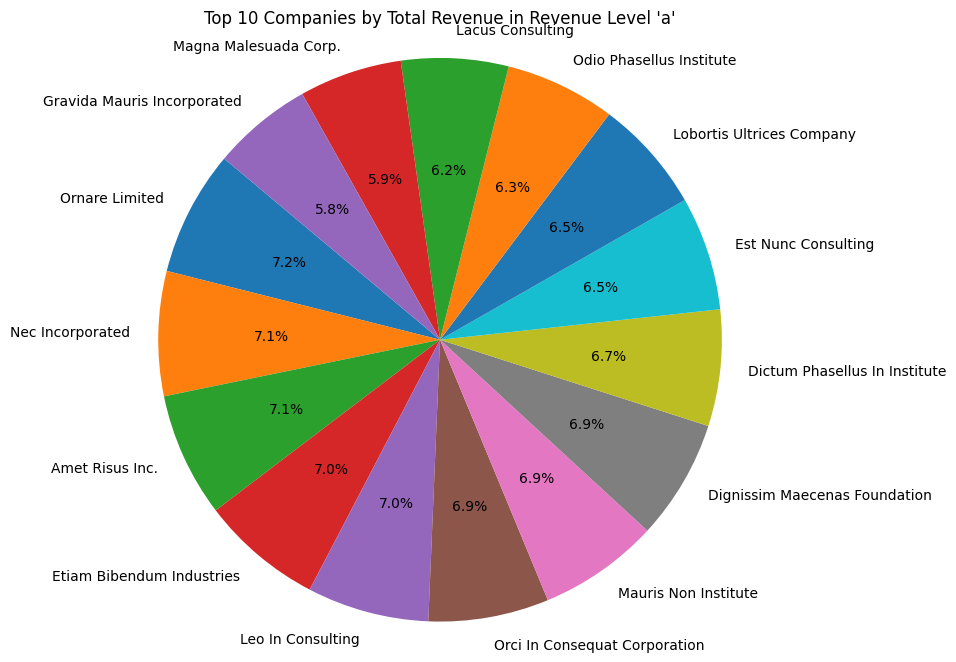

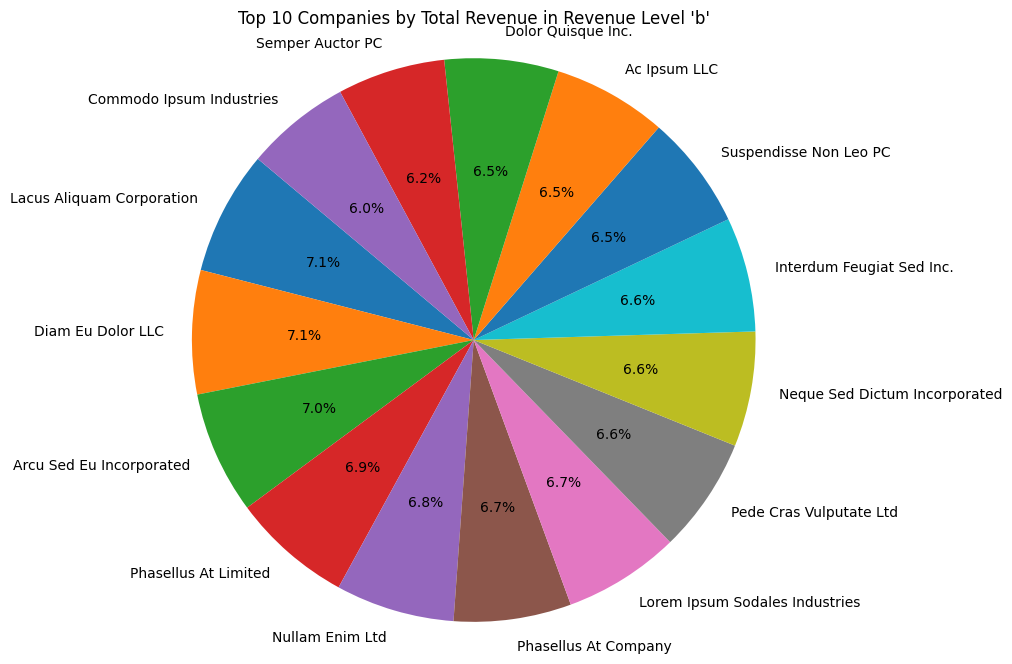

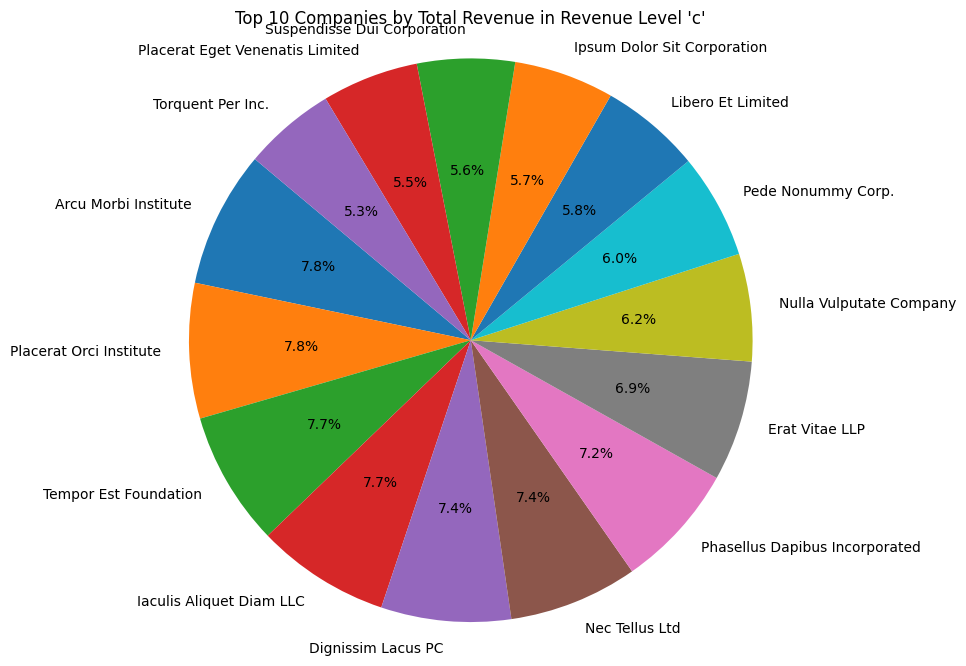

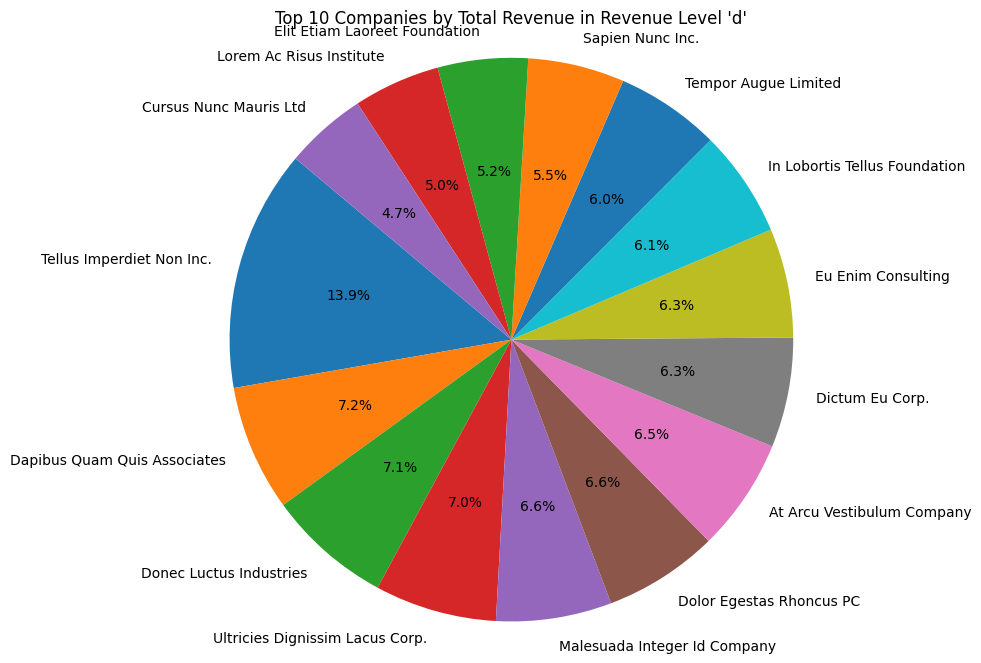

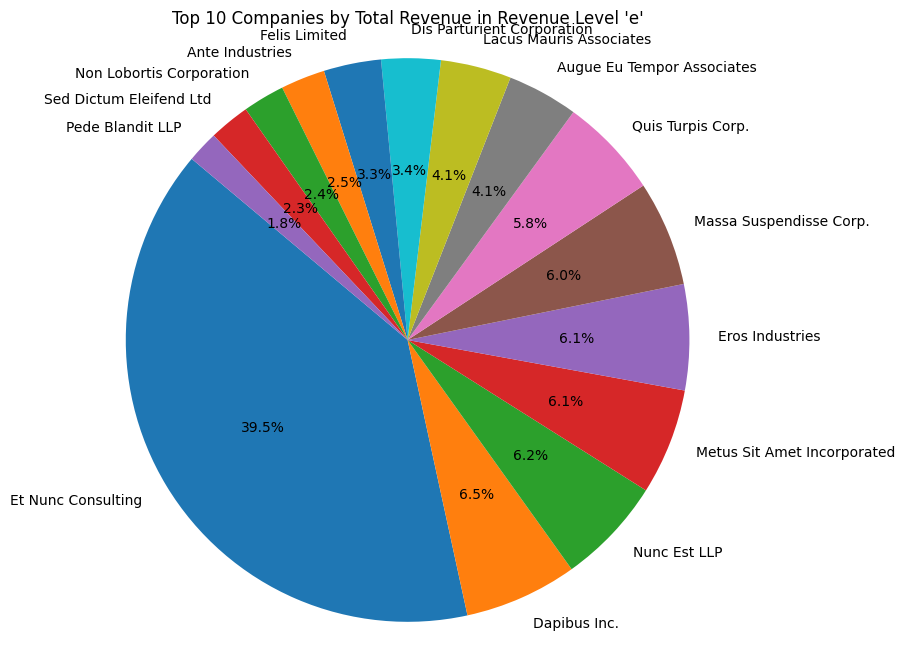

In [24]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

# Define revenue levels
revenue_levels = ['a', 'b', 'c', 'd', 'e']

# Loop through each revenue level
for level in revenue_levels:
    # Filter for the current revenue level
    revenue_level_df = merchant_profitability.filter(F.col("revenue_level") == level)
    
    # Group by company name and calculate the total revenue
    merchant_revenue = revenue_level_df.groupBy("name").agg(F.sum("total_revenue").alias("total_revenue"))
    
    # Sort by total revenue and select the top N companies (e.g., top 10)
    top_n_merchants = merchant_revenue.orderBy(F.desc("total_revenue")).limit(15).toPandas()
    
    # Check if there are any companies to plot
    if not top_n_merchants.empty:
        # Plot the pie chart
        plt.figure(figsize=(8, 8))
        plt.pie(top_n_merchants["total_revenue"], labels=top_n_merchants["name"], autopct='%1.1f%%', startangle=140)
        plt.title(f"Top 10 Companies by Total Revenue in Revenue Level '{level}'")
        plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

/tmp/ipykernel_147256/320666083.py:18: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="revenue_level", y="net_revenue", data=merchant_profitability_pd,


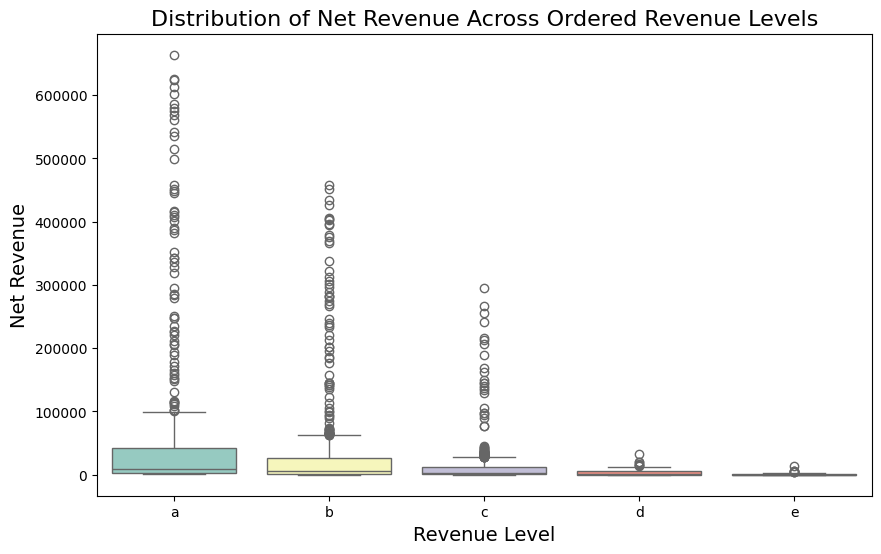

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the Spark DataFrame to Pandas for visualization
merchant_profitability_pd = merchant_profitability.select("revenue_level", "net_revenue").toPandas()

# Ensure that the revenue levels are ordered from 'a' to 'e'
ordered_levels = ['a', 'b', 'c', 'd', 'e']
merchant_profitability_pd['revenue_level'] = pd.Categorical(merchant_profitability_pd['revenue_level'], 
                                                           categories=ordered_levels, 
                                                           ordered=True)

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create the box plot using seaborn with the specified order
sns.boxplot(x="revenue_level", y="net_revenue", data=merchant_profitability_pd, 
            palette="Set3", order=ordered_levels)

# Set the plot's title and labels
plt.title("Distribution of Net Revenue Across Ordered Revenue Levels", fontsize=16)
plt.xlabel("Revenue Level", fontsize=14)
plt.ylabel("Net Revenue", fontsize=14)

# Show the plot
plt.show()